# **Naive bayes**
## Integrantes:
* Luis Augusto Araujo Lechuga
* Luis Enrique Flores Aquino
* Manuel Humberto Velarde Flores
* Mileydy Ninatay Diaz 
* Milagros YaraHuaman Rojas
* Gonzalo Gutierrez Daza
#### Este notebook revisaremos el algoritmo de clasificacion de Aprendizaje Automatico Naive bayes. Usaremos el conjunto de datos [bank-full.csv (Ensemble Techniques)](https://www.kaggle.com/krantiswalke/bankfullcsv )
#### **En este notebook:**
 #### *Parte 1:* Preparación de Datos y análisis del Dataset
 #### *Parte 2:* Implementación de Nayve Bayes

# **PARTE1**
# **Preparación de Datos y análisis del Dataset**

## **1. Librerías a usar para el preprocessing**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
import collections

In [2]:
import findspark
findspark.init()
 
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()

## **2. Importar dataset**


### Descripción del dataset 
***Nombre:*** Bank-full
Este dataset está relacionado con campañas de marketing de una entidad bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas.

***Dominio:*** Banco

***Contexto:*** Aprovechar la información del cliente es fundamental para la mayoría de las empresas. En el caso de un banco, los atributos de los clientes como los que se mencionan a continuación pueden ser cruciales en la estrategia de una campaña de marketing al lanzar un nuevo producto.

***Objetivo:***
El objetivo de la clasificación es predecir si el cliente suscribirá (sí/no) un depósito a plazo (variable y).
Referencia: 
[más información sobre el dataset](https://www.kaggle.com/krantiswalke/bankfullcsv)



In [3]:
data = 'Data/bank-full.csv'
df = pd.read_csv(data, sep=',')
columnas = df.columns
columnas = [x for x in columnas]
data = df.to_numpy()
data = map(tuple, data)
data = tuple(data)
data = [x for x in data]
dataRDD = sc.parallelize(data, 4)

In [4]:
print(columnas)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'Target']


In [5]:
# DEFINIMOS A LAS COLUMNAS CATEGORICAS Y LAS NUMERICAS
ColCategoricas = ['job','marital','education','default','housing','loan','contact','day','month','poutcome']
ColNumericas = ['age','balance','duration','campaign','pdays','previous']

## **3. Análisis exploratorio de datos** <a class="anchor" id="7"></a>



> "El análisis exploratorio de datos es un proceso de investigación en el que se usan estadísticas de resumen y herramientas gráficas para llegar a conocer los datos y comprender lo que se puede averiguar de ellos."


Se busca hacer un analisis exploratorio de datos a nuestro dataset para poder conocer las dimensiones de este asi como las propiedades dentro de sus tipos de variables

### Veremos las dimensiones del dataset

In [6]:
cantTuplas = dataRDD.count()
print(f'Cantidad de tuplas: {cantTuplas} || Cantidad de columnas: {len(columnas)}')

Cantidad de tuplas: 45211 || Cantidad de columnas: 17


Podemos ver que hay 45211 instancias y 17 atributos en el conjunto de datos.

Analizando la columna 'day'

In [7]:
def GraficarColCat(NCol):
    """Grafica los resultados de cada columna basado en la salida.

    Args:
        NCol: Numero de la columna

    """
    ColXtargetRDD = dataRDD.map(lambda x: (str(x[NCol])+'-'+x[-1],1))
    countColTargetRDD = ColXtargetRDD.reduceByKey(lambda a,b:a+b).map(lambda x: (x[0].split('-')[0],[x[0].split('-')[1],x[1]]))
    GroupByColRdd = countColTargetRDD.reduceByKey(lambda a,b: sorted([a,b]))
    dataCol = GroupByColRdd.collect()
    dataCol.sort()
    names = []
    valuesSI = []
    valuesNO = []
    for tupla in dataCol:
        names.append(tupla[0])
        valuesNO.append(tupla[1][0][1])
        valuesSI.append(tupla[1][1][1])
    rango = np.arange(1,len(names)+1)
    TotalNo = sum(valuesNO)
    TotalSI = sum(valuesSI)
    valuesNO = [x/TotalNo*100 for x in valuesNO]
    valuesSI = [x/TotalSI*100 for x in valuesSI]
    plt.title('APTO & NO APTO')
    plt.xlabel(f'Columna -> {columnas[NCol]}')
    plt.ylabel('Porcentaje')
    plt.plot(rango, valuesNO, color = "red", linewidth = 1.5, linestyle = "-.", label = "NO APTO")
    plt.plot(rango, valuesSI, marker = '+', linestyle = '-', label = 'APTO')
    plt.legend(loc = "upper left")
    plt.show()
    for k in range(len(rango)):
        print(f'{rango[k]} -> {names[k]}',end=' | ')
    print('')

In [8]:
#Calculamos la posición de cada columna categorica
PosCategoricas = [columnas.index(x) for x in ColCategoricas]

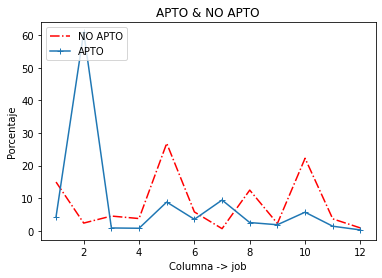

1 -> admin. | 2 -> blue | 3 -> entrepreneur | 4 -> housemaid | 5 -> management | 6 -> retired | 7 -> self | 8 -> services | 9 -> student | 10 -> technician | 11 -> unemployed | 12 -> unknown | 


In [9]:
GraficarColCat(PosCategoricas[0])

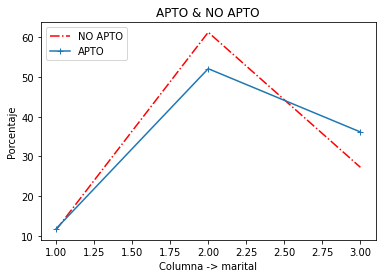

1 -> divorced | 2 -> married | 3 -> single | 


In [10]:
GraficarColCat(PosCategoricas[1])

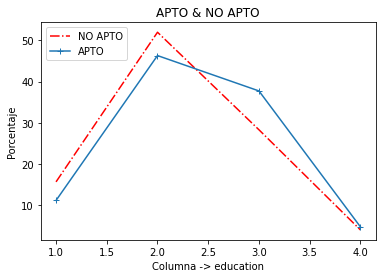

1 -> primary | 2 -> secondary | 3 -> tertiary | 4 -> unknown | 


In [11]:
GraficarColCat(PosCategoricas[2])

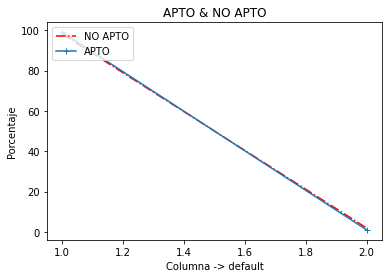

1 -> no | 2 -> yes | 


In [12]:
GraficarColCat(PosCategoricas[3])

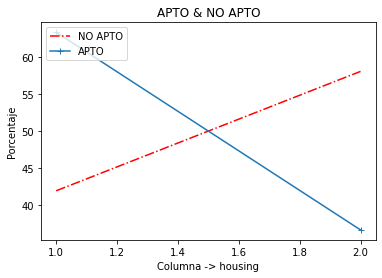

1 -> no | 2 -> yes | 


In [13]:
GraficarColCat(PosCategoricas[4])

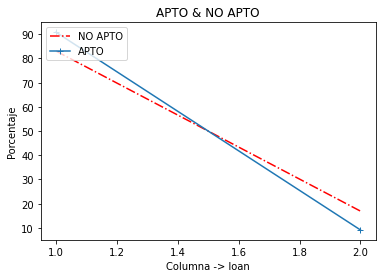

1 -> no | 2 -> yes | 


In [14]:
GraficarColCat(PosCategoricas[5])

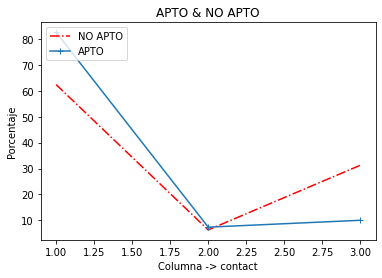

1 -> cellular | 2 -> telephone | 3 -> unknown | 


In [15]:
GraficarColCat(PosCategoricas[6])

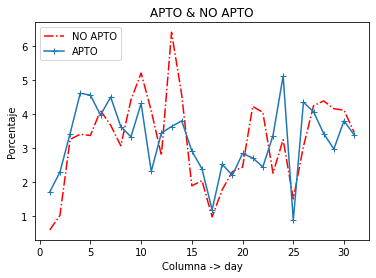

1 -> 1 | 2 -> 10 | 3 -> 11 | 4 -> 12 | 5 -> 13 | 6 -> 14 | 7 -> 15 | 8 -> 16 | 9 -> 17 | 10 -> 18 | 11 -> 19 | 12 -> 2 | 13 -> 20 | 14 -> 21 | 15 -> 22 | 16 -> 23 | 17 -> 24 | 18 -> 25 | 19 -> 26 | 20 -> 27 | 21 -> 28 | 22 -> 29 | 23 -> 3 | 24 -> 30 | 25 -> 31 | 26 -> 4 | 27 -> 5 | 28 -> 6 | 29 -> 7 | 30 -> 8 | 31 -> 9 | 


In [16]:
GraficarColCat(PosCategoricas[7])

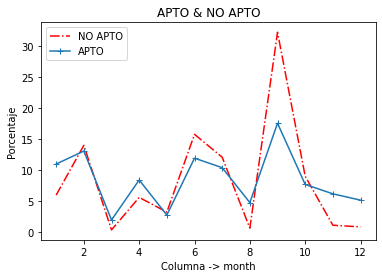

1 -> apr | 2 -> aug | 3 -> dec | 4 -> feb | 5 -> jan | 6 -> jul | 7 -> jun | 8 -> mar | 9 -> may | 10 -> nov | 11 -> oct | 12 -> sep | 


In [17]:
GraficarColCat(PosCategoricas[8])

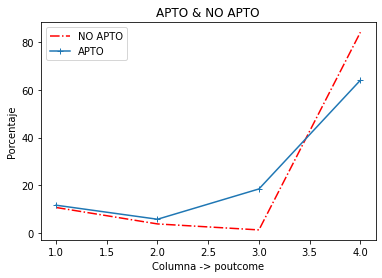

1 -> failure | 2 -> other | 3 -> success | 4 -> unknown | 


In [18]:
GraficarColCat(PosCategoricas[9])

#### Analisis de las graficas

Cómo se puede apreciar en la gráfica las columnas:

**default:** Dentro de la columna default, los resultados vienen a ser los mismos

**loan:** Dentro de la columna loan, los resultados vienen a ser muy similares

Conclusion:
No se presenta una diferencia por lo que se procede eliminarlas

## **5. Normalizar valores numéricos**

In [19]:
def MaxMinScaler(minVal, maxVal, Tupla, NCol):
    """Normaliza la columna, segun max min.

    Args:
        minVal (int): El valor maximo de los datos
        maxVal (int): El valor minimo de los datos
        Tupla  (tupla): Una tupla que viene a ser toda una fila 
        NCol   (int): El numero de columna en el que se trabajra

    Returns:
        tuple: La tupla con el valor de la columna normalizado.
    """
    Tupla = list(Tupla)
    Tupla[NCol] = (Tupla[NCol]-minVal)/(maxVal-minVal)
    return list(Tupla)
    
def EscalarColumna(colNum):
    tempRDD = dataRDD.map(lambda x: (x[colNum]))
    maxVal = tempRDD.max()
    minVal = tempRDD.min()
    return dataRDD.map(lambda x: MaxMinScaler(minVal,maxVal,x,colNum))

In [20]:
#Calculamos la posición de cada columna numerica
PosNumericas = [columnas.index(x) for x in ColNumericas]
PosNumericas

[0, 5, 11, 12, 13, 14]

In [21]:
for val in PosNumericas:
    dataRDD = EscalarColumna(val)
    print(f'columna {columnas[val]} || normalizada')

columna age || normalizada
columna balance || normalizada
columna duration || normalizada
columna campaign || normalizada
columna pdays || normalizada
columna previous || normalizada


## **6. Eliminación de columnas inecesarias**

> Se eliminan las columnas innecesarias para que estas no sean analizadas 

In [22]:
#Funciones de eliminacion
pos = [columnas.index('default'),columnas.index('loan')]
columnas = columnas[0:pos[0]]+columnas[pos[0]+1:pos[1]]+columnas[pos[1]+1:]
dataRDD = dataRDD.map(lambda x: x[0:pos[0]]+x[pos[0]+1:pos[1]]+x[pos[1]+1:])

In [23]:
x = dataRDD.collect()

## **7. Dividir los datos en conjuntos de entrenamiento y de test**

 Se divide el dataste en una proporcion de 7 a 3
 - 7 para el train
 - 3 para el test

In [24]:
TrainRDD, TestRDD = dataRDD.randomSplit([7,3],seed=789456)
print(f'Train -> {TrainRDD.count()}')
print(f'Test -> {TestRDD.count()}')
print(f'Total -> {dataRDD.count()}')

Train -> 31630
Test -> 13581
Total -> 45211


# **PARTE 2**
# **Implementacion de Naive bayes**

Basado en el teorema de Bayes,, esta tecnica de clasificacion estadistica, se enfoca en la clasificación.
En estos modelos llamados "Naive" los predictores son independientes entre si. Teniendo en cuenta que una caracteristica de un dataset no esta relacionada con la presencia de otra caracteristica

Los modelos nos ofrecen un comportamiento bueno debido a la simplicidad, donde una forma de calcular la probabilidad poseterior de que ocurra un evento A dadas probabilidades de eventos anteriores y se calcula de la siguiente manera:
$$ \mathbf{P(A|R) }  = \frac{P(R|A)P(A)}{P(R)} $$

donde: 
* $$P(A): Probabilidad de A$$
* $$P(R|A): Probabilidad de que se de R dado A$$
* $$P(E): Probabilidad de R$$
* $$P(A|R): Probabilidad de que se de A dado R$$


## **1. Dependencias del entorno PySpark**

Se requiere agregar as dependencias del spark para poder ejecutar el codigo dentro de un cuadernillo de jupyter

## **2. Creación de las funciones necesarias**

Al tener dos tipos de datos en las columnas de nuestro dataset es necesario saber que cada uno de estos tiene que ser tratado de una manera distinta, por ello se creo:
* `ResColNum`
* `ResColCategorica`

las cuales se encargan de resumir la informacion de una cadena numerica o categorica segun sea necesario, haciendo uso de las funciones
* `CalcMeanSTD (numerico)`
* `ConvertirPorcentaje (categorico)`

In [25]:
def CalcMeanSTD(Valores):
    meanVals = np.mean(Valores)
    stdDev = np.std(Valores,ddof=1)
    #funcNormDist = lambda x: 1/(np.sqrt(2*np.pi)*stdDev)*np.e**(-(x-meanVals)**2/(2*stdDev**2))
    #print(f'MEAN -> {meanVals}')
    #print(f'STD -> {stdDev}')
    return {'mean':meanVals,'std':stdDev}
#RESUME UNA COLUMNA DE TIPO NUMÉRICA
def ResColNum(dataRDD,NumCol,NumColKey):
    intento01 = dataRDD.groupBy(lambda x: x[NumColKey]) #Agrupamos los datos segun la variable de salida
    intento02 = intento01.map(lambda x: (x[0],[y[NumCol] for y in x[1]])) #Guardar solo la columna y la salida
    intento03 = intento02.map(lambda x: (x[0],CalcMeanSTD(x[1]))) #Calculamos el mean y el std
    return intento03.collect() # Retornamos los valores encontrado

def ConvertirPorcentaje(CounterApar):
    dictPorcentaje = {}
    for key in Salida.keys():
        #print(f'{key} -> {CounterApar[key]}')
        #print(f'{key} -> {CounterApar[key]/Salida[key]}')
        dictPorcentaje[key] = CounterApar[key]/Salida[key]
    return dictPorcentaje

def ResColCategorica(dataRDD,NumCol,NumColKey):
    intento01 = dataRDD.groupBy(lambda x: x[NumCol]) # Agrupar mediante columna 0
    intento02 = intento01.map(lambda x: (x[0],[y[NumColKey] for y in x[1]])) #Guardar solo el tipo y la salida
    intento03 = intento02.map(lambda x: (x[0],collections.Counter(x[1]))) #Contar apariciones y total
    #intento04 = intento03.map(lambda x: (x[0], ConvertirPorcentaje(x[1]))) #Convertir a porcentaje y convertir a diccionario
    intento04 = intento03.map(lambda x: (x[0], ConvertirPorcentaje(x[1]))) #Convertir a porcentaje y convertir a diccionario
    return intento04.collect()

## 3. Se busca determinar los valores de cada salida categorica, que en este caso viene a ser una salida binaria

In [26]:
# Determinar valores de salida categórica
Salida = TrainRDD.map(lambda x: (x[-1],1)).groupByKey().map(lambda x:(x[0],sum(x[1]))).collect()
Salida = dict(Salida)
CantData = TrainRDD.count()
Salida_Keys = Salida.keys()
Salida_Keys = [x for x in Salida_Keys]
print(f'Cant Data -> {CantData}')
print(Salida)
print(Salida_Keys)

Cant Data -> 31630
{'no': 27890, 'yes': 3740}
['no', 'yes']


## **4. Aplicar Naive Bayes a los datos de entrenamiento**

Con un data set con una distribucion de 27953 datos negativos y 3694 datos positivos, se busca entrenar este modelo recorriendo las columnas definidas como numericas o categoricas para asi poder aplicar
`ResColCategorica` o `ResColNum` segun sea necesario

In [27]:
# CLASIFICAMOS CADA TIPO DE COLUMNA
TipoCols = ['num', 'cat', 'cat', 'cat', 'num', 'cat', 'cat', 'cat', 'cat', 'num', 'num', 'num', 'num', 'cat']
NumSal = len(columnas)-1
ResColumnas = {}
for k in range(len(TipoCols)):
    if(TipoCols[k]=='cat'):
        ResColumna = ResColCategorica(TrainRDD,k,NumSal)
    else:
        ResColumna = ResColNum(TrainRDD,k,NumSal)
    ResColumnas[columnas[k]] = ResColumna

In [28]:
#Mostramos resultado final
for key in ResColumnas:
    print(key)
    print(ResColumnas[key])
    print("==================")

age
[('no', {'mean': 0.2975790792212449, 'std': 0.1326012803284113}), ('yes', {'mean': 0.3056635877491492, 'std': 0.17349655045546986})]
job
[('retired', {'no': 0.04596629616349946, 'yes': 0.09358288770053476}), ('unemployed', {'no': 0.027285765507350304, 'yes': 0.037165775401069516}), ('unknown', {'no': 0.00627465041233417, 'yes': 0.0066844919786096255}), ('entrepreneur', {'no': 0.03420580853352456, 'yes': 0.02406417112299465}), ('admin.', {'no': 0.11280028684116171, 'yes': 0.1232620320855615}), ('services', {'no': 0.09372534958766583, 'yes': 0.06925133689839572}), ('self-employed', {'no': 0.03481534600215131, 'yes': 0.03342245989304813}), ('management', {'no': 0.20380064539261383, 'yes': 0.24385026737967913}), ('student', {'no': 0.016600932233775546, 'yes': 0.05320855614973262}), ('technician', {'no': 0.16808892076012907, 'yes': 0.16096256684491977}), ('blue-collar', {'no': 0.22828970957332378, 'yes': 0.13262032085561498}), ('housemaid', {'no': 0.02814628899247042, 'yes': 0.021925133

## **5. Evaluar modelo con los datos de prueba**

### *Aplicación de clasificador*

Se tiene un evaluador el cual se encarga de analizar dentro de un dicionario las posibilidades de cada valor encontrado dentro de las columnas , dependiendo si estas son categoricas o numericas.
Para luego poder evaluar las probabilidades de cada uno de estos

In [29]:
def Evaluar(TuplaEvaluar):
    ProbabilidadesTotales = {}
    for Caso in Salida_Keys:
        ProbTot = Salida[Caso]/CantData 
        for k in range(len(TuplaEvaluar)):
            if(TipoCols[k] == 'cat'):
                dataTemp = ResColumnas[columnas[k]]
                Encontrado = False
                i = 0
                P = 0
                while(not Encontrado):
                    if (dataTemp[i][0]==TuplaEvaluar[k]):
                        P = dataTemp[i][1][Caso] 
                        Encontrado=True
                    i+=1
                    if(i>=len(dataTemp)):
                        break
            else:
                dataTemp = ResColumnas[columnas[k]]
                Encontrado = False
                i = 0
                P = 0
                while(not Encontrado):
                    if (dataTemp[i][0]==Caso):
                        mean = dataTemp[i][1]['mean']
                        std = dataTemp[i][1]['std']
                        P = 1/(np.sqrt(2*np.pi)*std)*np.e**(-(TuplaEvaluar[k]-mean)**2/(2*std**2))
                        Encontrado=True
                    i+=1
                    if(i>=len(dataTemp)):
                        break
            ProbTot = ProbTot*P
        ProbabilidadesTotales[Caso]=ProbTot
        max_key = max(ProbabilidadesTotales, key=ProbabilidadesTotales.get)
    return(max_key)

def ContarAciertosErrores(tupla): #ACIERTOS, FALLOS
    RptReal = tupla[0]
    Acertadas = len([RptCalculada for RptCalculada in tupla[1] if RptCalculada==RptReal])
    Fallidas = len(tupla[1])-Acertadas
    #print(f'Fallidas: {Fallidas} | Acertadas: {Acertadas} | Total: {len(tupla[1])}')
    return((Acertadas,Fallidas))

In [30]:
TestEvalRDD = TestRDD.map(lambda x: (x[-1], Evaluar(x[0:-1]))) #Rpt real, Rpt calculada
TestGroupRDD = TestEvalRDD.groupBy(lambda x: x[0]).map(lambda x: (x[0],[a[1] for a in x[1]])) # Rpt real, [Rpts Calculadas de ese tipo]
TestMatrixConfRDD = TestGroupRDD.map(lambda x: (x[0],ContarAciertosErrores(x)))
DataMatrix = TestMatrixConfRDD.collect()

In [31]:
DataMatrix

[('no', (11128, 904)), ('yes', (806, 743))]

In [32]:
print('  MATRIZ DE CONFUSIÓN')
print(f'  |  V | F  ')
print(f'V |{DataMatrix[1][1][0]} | {DataMatrix[1][1][1]}')
print(f'F |{DataMatrix[0][1][1]} | {DataMatrix[0][1][0]}')

  MATRIZ DE CONFUSIÓN
  |  V | F  
V |806 | 743
F |904 | 11128
